## Connect To Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# root = "drive/MyDrive/ANNSSM/codes/Datasets"
root = "drive/MyDrive/CMP/"

## Importing Packages

In [3]:
import numpy as np
import pickle
import csv
from tqdm import tqdm
import pandas as pd
import tensorflow as tf

## Data Preparation

#### Load SUBTLEX data

In [4]:
# Loading subtlex data
SUBTLEX_df = pd.read_excel(root + 'Datasets/SUBTLEX_Zipf.xlsx')

# renaming columns for latter merge use and dropping unneccery columns
SUBTLEX_df.rename(columns={'Word':'string', 'Zipf-value': 'zipf'}, inplace=True)
SUBTLEX_df.drop(SUBTLEX_df.columns[1:-1], axis=1, inplace=True)
SUBTLEX_df.head()

,string,zipf
0,a,7.309360
1,aa,3.236317
2,aaa,2.706807
3,aah,4.721425
4,aahed,1.592864


In [5]:
def categorise_by_zipf(row):
    """
    categorizing data string as High frequency word (HF),
    Low frequency word (LF) and non-word (NW) by zipf value

    Parameters
    ----------
        row: pandas series
            pandas dataframe's row containing label and zipf column
    
    Returns:
        category (str): HF, LF, NW
    """
    category = ''
    if row['label'] == 0:
        category = 'NW'
    elif row['label'] == 1 and row['zipf'] > 3:
        category = 'HF'
    else:
        category = 'LF'
    return category

# Load ELP data and Merge with Subtlex data

Reading **words** and **non-words** datasets



In [6]:
words = []
with open(root+"Datasets/Items.csv", 'r') as file:
    reader = csv.reader(file)
    for index, row in enumerate(tqdm(reader)):
        if index == 0:
            continue
        words.append([row[0], row[2].replace(',', ''), 'word'])


nonwords = []
with open(root+"Datasets/nonword.csv", 'r') as file:
    reader = csv.reader(file)
    for index, row in enumerate(tqdm(reader)):
        if index == 0:
            continue
        nonwords.append([row[0], 'nonword'])


40483it [00:00, 217590.17it/s]
40342it [00:00, 959248.35it/s]


Adding appropriate encodings for extra information for both words and non-words

In [7]:
for w in words:
    w.insert(3, [1, 0])
    w.insert(4, 1)

for nw in nonwords:
    nw.insert(1, 0)
    nw.insert(3, [0, 1])
    nw.insert(4, 0)

In [8]:
data_df = pd.DataFrame(words + nonwords,
               columns =['string', 'freq', 'type', 'code', 'label'])

In [9]:
data_df

,string,freq,type,code,label
0,a,10610626,word,"[1, 0]",1
1,aah,222,word,"[1, 0]",1
2,Aaron,10806,word,"[1, 0]",1
3,aback,387,word,"[1, 0]",1
4,abacus,513,word,"[1, 0]",1
...,...,...,...,...,...
80818,declassificarion,0,nonword,"[0, 1]",0
80819,antifundamentadast,0,nonword,"[0, 1]",0
80820,transcontanental,0,nonword,"[0, 1]",0
80821,iv,0,nonword,"[0, 1]",0


Loading elp data and merging them with subtlex data

In [10]:
# loading elp words and non-words as seprate dataframes
elp_words = pd.DataFrame(words, columns =['string', 'freq', 'represention', 'code', 'label'])
elp_nonwords = pd.DataFrame(nonwords, columns =['string', 'freq', 'represention', 'code', 'label'])

# mergeing elp words with subtlex words to get zipf for each elp words
# elp words that does not have zipf will be droped
elp_words = pd.merge(elp_words, SUBTLEX_df, on='string', how='left').dropna()
elp_df = pd.concat([elp_words, elp_nonwords])

# 
elp_df.fillna(0, inplace=True)
elp_df['category'] = elp_df.apply(lambda row: categorise_by_zipf(row), axis=1)
elp_df.drop_duplicates(subset=['string'], inplace=True)

In [11]:
elp_df = elp_df.sample(frac=1.0)
elp_df.head()

,string,freq,represention,code,label,zipf,category
20838,yumps,0,nonword,"[0, 1]",0,0.000000,NW
4044,boxcars,89,word,"[1, 0]",1,2.246077,LF
8062,creedam,0,nonword,"[0, 1]",0,0.000000,NW
15334,granike's,0,nonword,"[0, 1]",0,0.000000,NW
29316,repomses,0,nonword,"[0, 1]",0,0.000000,NW


Splitting train and test datasets

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(elp_df['string'],elp_df['label'], stratify=elp_df['label'], test_size=.2)

In [13]:
y_train

12078    0
37766    0
35210    1
11804    0
19305    1
        ..
21956    1
25474    1
29595    0
30333    1
26550    0
Name: label, Length: 59453, dtype: int64

Add encodings for train and test outputs representing the correct labels of each entry in the dataset

In [14]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [15]:
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_test

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## Building the Model

In [16]:
!pip install "tensorflow-text==2.8.*"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import tensorflow_hub as hub
import tensorflow_text as text

In [18]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing', trainable=False)

encoder_inputs = preprocessing_layer(text_input)
#version1: small bert
# encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1", name='BERT_encoder', trainable=False)

#version2: bert_en_uncased_L-12_H-768_A-12
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", name='BERT_encoder', trainable=False)

outputs = encoder(encoder_inputs)

# Neural network layers
net = outputs["sequence_output"][:, 0, :]
# net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(300, activation="relu", name="dense1")(net)
net = tf.keras.layers.Dense(300, activation="relu", name="dense2")(net)
net = tf.keras.layers.Dropout(0.25)(net)
net = tf.keras.layers.Dense(100, activation="relu", name="dense3")(net)
net = tf.keras.layers.Dense(50, activation="relu", name="dense4")(net)
net = tf.keras.layers.Dropout(0.25)(net)
net = tf.keras.layers.Dense(10, activation="relu", name="dense5")(net)
net = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(net)
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [net])

In [19]:
# tf.keras.utils.plot_model(model, to_file='drive/MyDrive/ANNSSM/codes/BERT-RDM/BERT_model.png', show_shapes=True)
tf.keras.utils.plot_model(model, to_file='drive/MyDrive/CMP/Plots/Classification/BERT_model.pdf', show_shapes=True)


In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size = 64,
    callbacks=[
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss',
          patience=5,
          restore_best_weights=True
      )
  ]
)

Epoch 1/10
929/929 [==============================] - 819s 868ms/step - loss: 0.2475 - accuracy: 0.8997 - val_loss: 0.2114 - val_accuracy: 0.9166
Epoch 2/10
929/929 [==============================] - 807s 869ms/step - loss: 0.1996 - accuracy: 0.9205 - val_loss: 0.2031 - val_accuracy: 0.9170
Epoch 3/10
929/929 [==============================] - 804s 865ms/step - loss: 0.1866 - accuracy: 0.9272 - val_loss: 0.1919 - val_accuracy: 0.9266
Epoch 4/10
929/929 [==============================] - 812s 874ms/step - loss: 0.1763 - accuracy: 0.9305 - val_loss: 0.1848 - val_accuracy: 0.9257
Epoch 5/10
929/929 [==============================] - 801s 863ms/step - loss: 0.1696 - accuracy: 0.9334 - val_loss: 0.1854 - val_accuracy: 0.9288
Epoch 6/10
929/929 [==============================] - 801s 863ms/step - loss: 0.1632 - accuracy: 0.9357 - val_loss: 0.1873 - val_accuracy: 0.9273
Epoch 7/10
929/929 [==============================] - 803s 865ms/step - loss: 0.1578 - accuracy: 0.9385 - val_loss: 0.1891 -

Saving the model

In [22]:
model.save("drive/MyDrive/CMP/BERT-RDM/BERT_model")

## Predicted Probabilities on full dataset

In [23]:
from sklearn import metrics

full_dataset_predictions = model.predict(np.array(elp_df['string']))

#### Classification results

In [24]:
print(metrics.classification_report(elp_df['label'].to_numpy(),  np.argmax(full_dataset_predictions, axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.9299    0.9516    0.9406     40339
           1     0.9409    0.9148    0.9276     33978

    accuracy                         0.9348     74317
   macro avg     0.9354    0.9332    0.9341     74317
weighted avg     0.9349    0.9348    0.9347     74317



In [25]:
acc_score = (metrics.accuracy_score(elp_df['label'].to_numpy(),  np.argmax(full_dataset_predictions, axis=1)))
acc_score

0.9347524792443183

#### Confusion Matrix

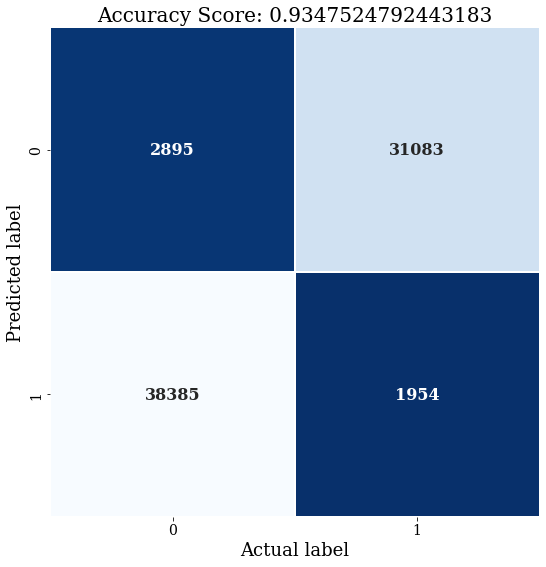

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

cm = metrics.confusion_matrix(np.argmax(np.array(list(elp_df['code'])), axis=1), np.argmax(full_dataset_predictions, axis=1))
plt.figure(figsize=(9,9))
hm = sns.heatmap(cm, annot=True, fmt=".0f", cbar=False, linewidths=.5, square = True, cmap = 'Blues_r',
            annot_kws={
                'fontsize': 16,
                'fontweight': 'bold'
            });
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 14)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 14)
hm.set_xlabel('Actual label', fontsize=18);
hm.set_ylabel('Predicted label', fontsize=18);
all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
plt.title(all_sample_title, size = 20);
plt.savefig(root+'Plots/Classification/BERT.pdf')

#### Pridected Probabilites for each words category and non-words

In [27]:
elp_df['word_prob']=full_dataset_predictions[:,1]
elp_df['nword_prob']=full_dataset_predictions[:,0]

In [28]:
elp_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'nword_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                          nword_prob  \
              mean       std  count       max           min       mean   
category                                                                 
HF        0.962141  0.123653  14333  1.000000  3.443887e-03   0.037859   
LF        0.817499  0.252307  19645  1.000000  1.697977e-04   0.182502   
NW        0.087640  0.169903  40339  0.999961  4.384413e-07   0.912360   

                                                   
               std  count       max           min  
category                                           
HF        0.123653  14333  0.996556  1.043489e-08  
LF        0.252307  19645  0.999830  4.145263e-08  
NW        0.169903  40339  1.000000  3.854624e-05

## Save Predicted Probabilities of full dataset

In [29]:
word_df_to_save = elp_df.drop(['represention', 'code'], axis=1)

In [30]:
word_df_to_save

,string,freq,label,zipf,category,word_prob,nword_prob
20838,yumps,0,0,0.000000,NW,0.001433,0.998567
4044,boxcars,89,1,2.246077,LF,0.994324,0.005676
8062,creedam,0,0,0.000000,NW,0.004419,0.995581
15334,granike's,0,0,0.000000,NW,0.000569,0.999431
29316,repomses,0,0,0.000000,NW,0.005357,0.994643
...,...,...,...,...,...,...,...
13187,farmhouse,234,1,3.124343,HF,0.999835,0.000165
11924,elwrap,0,0,0.000000,NW,0.015441,0.984559
15413,plazing,0,0,0.000000,NW,0.028408,0.971592
3219,sirths,0,0,0.000000,NW,0.001985,0.998015


In [31]:
word_df_to_save.to_csv(root+"Datasets/BERT.csv", header=0, index=False)